<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#4-9.-프로젝트:-Vocabulary-Size를-변경해서-시도해보기" data-toc-modified-id="4-9.-프로젝트:-Vocabulary-Size를-변경해서-시도해보기-1">4-9. 프로젝트: Vocabulary Size를 변경해서 시도해보기</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#1.-모든-단어-사용" data-toc-modified-id="1.-모든-단어-사용-1.0.1">1. 모든 단어 사용</a></span></li><li><span><a href="#2.-빈도수-상위-5,000개의-단어만-사용" data-toc-modified-id="2.-빈도수-상위-5,000개의-단어만-사용-1.0.2">2. 빈도수 상위 5,000개의 단어만 사용</a></span></li><li><span><a href="#3.-직접-단어-갯수를-설정해서-사용" data-toc-modified-id="3.-직접-단어-갯수를-설정해서-사용-1.0.3">3. 직접 단어 갯수를 설정해서 사용</a></span></li><li><span><a href="#4.-딥러닝-모델과-비교해-보기" data-toc-modified-id="4.-딥러닝-모델과-비교해-보기-1.0.4">4. 딥러닝 모델과 비교해 보기</a></span><ul class="toc-item"><li><span><a href="#4-1.-RNN" data-toc-modified-id="4-1.-RNN-1.0.4.1">4-1. RNN</a></span></li><li><span><a href="#4-2.-1D-CNN" data-toc-modified-id="4-2.-1D-CNN-1.0.4.2">4-2. 1D CNN</a></span></li><li><span><a href="#4-3.-Results" data-toc-modified-id="4-3.-Results-1.0.4.3">4-3. Results</a></span></li></ul></li><li><span><a href="#루브릭" data-toc-modified-id="루브릭-1.0.5">루브릭</a></span></li><li><span><a href="#Postscript" data-toc-modified-id="Postscript-1.0.6">Postscript</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-1.0.7">Reference</a></span></li></ul></li></ul></li></ul></div>

# 4-9. 프로젝트: Vocabulary Size를 변경해서 시도해보기

지금까지는 모델을 변경하고, 모델을 조합해서 성능을 올리는 일에 힘썼습니다. 그런데 어쩌면 성능을 높이는 방법은 단순히 모델을 조정하는 일이 한정되지 않을 수 있습니다. 데이터의 전처리는 모델의 성능에 영향을 직접적으로 줍니다. 특히나 Bag of Words를 기반으로 하는 DTM이나 TF-IDF의 경우, 사용하는 단어의 수를 어떻게 결정하느냐에 따라서 성능에 영향을 줄 수 있겠죠.

중요도가 낮은 단어들까지 포함해서 너무 많은 단어를 사용하는 경우에도 성능이 저하될 수 있고, 반대로 너무 적은 단어들을 사용해도 성능이 저하될 수 있습니다. 그리고 이렇게 변화된 단어의 수는 또 어떤 모델을 사용하느냐에 따라 유리할 수도, 불리할 수도 있습니다.

단어의 수에 따라서 모델의 성능이 어떻게 변하는지 테스트해 봅시다.

```
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)
```

앞서 num_words로 사용할 단어의 수를 조정할 수 있다는 것을 배웠습니다. 빈도수가 많은 순서대로 나열했을 때, num_words의 인자로 준 정숫값만큼의 단어를 사용하고 나머지 단어는 전부 <unk>로 처리하는 원리였었죠.

아래의 두 가지 경우에 대해서 지금까지 사용했던 모델들의 정확도를 직접 확인해 보세요.

In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB  # 다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score  # 정확도 계산

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import keras.backend as K
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Conv1D, GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
gpus = tf.config.experimental.list_logical_devices('GPU')

if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print(f'Running on multiple GPUs {[gpu.name for gpu in gpus]}')
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy()
    print(f'Running on single GPU {gpus[0].name}')
else:
    strategy = tf.distribute.get_strategy()
    print('Running on CPU')

print(f'Number of accelerators: {strategy.num_replicas_in_sync}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Running on multiple GPUs ['/device:GPU:0', '/device:GPU:1']
Number of accelerators: 2


In [3]:
class TestModels():

    def __init__(self):
        self.results = pd.DataFrame(columns=['model', 'num_words', 'accuracy'])

        self.dtmvector = CountVectorizer()
        self.tfidf_transformer = TfidfTransformer()

        self.mnb = MultinomialNB()
        self.cnb = ComplementNB()
        self.lr = LogisticRegression(C=10000, penalty='l2', n_jobs=-1)
        self.lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
        self.dtc = DecisionTreeClassifier(max_depth=10, random_state=0)
        self.rfc = RandomForestClassifier(
            n_estimators=5, random_state=0, n_jobs=-1)
        self.gbc = GradientBoostingClassifier(random_state=0)
        self.vc = VotingClassifier(estimators=[('lr', LogisticRegression(C=10000, penalty='l2', n_jobs=-1)),
                                               ('cb', ComplementNB()),
                                               ('grbt', GradientBoostingClassifier(random_state=0))],
                                   voting='soft', n_jobs=-1)
        self.models = [self.mnb, self.cnb, self.lr, self.lsvc,
                       self.dtc, self.rfc, self.gbc, self.vc]

    def reuters_load_data(self, num_words: int = None):
        (self.x_train, self.y_train), (self.x_test, self.y_test) = reuters.load_data(
            num_words=num_words, test_split=0.2)

    def decode_data(self):
        word_index = reuters.get_word_index(path="reuters_word_index.json")
        index_to_word = {index+3: word for word, index in word_index.items()}
        # index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
        for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
            index_to_word[index] = token

        # decode x_train
        decoded = []
        for i in range(len(self.x_train)):
            t = ' '.join([index_to_word[index] for index in self.x_train[i]])
            decoded.append(t)
        self.x_train = decoded

        # decode x_test
        decoded = []
        for i in range(len(self.x_test)):
            t = ' '.join([index_to_word[index] for index in self.x_test[i]])
            decoded.append(t)
        self.x_test = decoded

    def fit_dtm_tfidf(self):
        self.x_train_dtm = self.dtmvector.fit_transform(self.x_train)  # DTM
        self.tfidfv = self.tfidf_transformer.fit_transform(
            self.x_train_dtm)  # TF-IDF

        self.x_test_dtm = self.dtmvector.transform(
            self.x_test)  # 테스트 데이터를 DTM으로 변환
        self.tfidfv_test = self.tfidf_transformer.transform(
            self.x_test_dtm)  # DTM을 TF-IDF 행렬로 변환

    def test_models(self, num_words=None):
        self.reuters_load_data(num_words)
        self.decode_data()
        self.fit_dtm_tfidf()

        for model in self.models:
            model.fit(self.tfidfv, self.y_train)
            predicted = model.predict(self.tfidfv_test)  # 테스트 데이터에 대한 예측
            self.results = self.results.append({'model': model.__class__.__name__,
                                                'num_words': num_words,
                                                'accuracy': accuracy_score(self.y_test, predicted)},
                                               ignore_index=True)

    def test_rnn(self, num_words=None):
        tf.keras.backend.clear_session()
        
        self.reuters_load_data(num_words)

        if num_words is None:
            # 30981 <- max(np.concatenate((np.concatenate(self.x_train), np.concatenate(self.y_train)), axis=None))
            # 1 <- min(np.concatenate((np.concatenate(self.x_train), np.concatenate(self.y_train)), axis=None))
            self.num_words = 30982
        else:
            # 로이터 데이터 값 범위 = 1~(num_words-1)
            self.num_words = num_words

        max_len = max(len(l) for l in np.concatenate(
            (self.x_train, self.x_test), axis=0))
        self.x_train = pad_sequences(self.x_train, maxlen=max_len)
        self.x_test = pad_sequences(self.x_test, maxlen=max_len)

        self.y_train = to_categorical(self.y_train, num_classes=46)
        self.y_test = to_categorical(self.y_test, num_classes=46)

        es = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4)
        mc = ModelCheckpoint('GDNLP_04_LSTM.h5', monitor='val_acc',
                             mode='max', verbose=1, save_best_only=True)

        with strategy.scope():
            model = Sequential()
            model.add(Embedding(self.num_words, 120))
            model.add(LSTM(120))
            model.add(Dense(46, activation='softmax'))

            model.compile(optimizer='adam',
                          loss='categorical_crossentropy', metrics=['acc'])

        history = model.fit(self.x_train, self.y_train, batch_size=128, epochs=1000,
                            callbacks=[es, mc],  validation_data=(self.x_test, self.y_test))

        loaded_model = load_model('GDNLP_04_LSTM.h5')

        self.results = self.results.append({'model': 'LSTM',
                                            'num_words': self.num_words,
                                            'accuracy': loaded_model.evaluate(self.x_test, self.y_test)[1]},
                                           ignore_index=True)

    def test_1dcnn(self, num_words=None):
        tf.keras.backend.clear_session()
        
        self.reuters_load_data(num_words)

        if num_words is None:
            # 30981 <- max(np.concatenate((np.concatenate(self.x_train), np.concatenate(self.y_train)), axis=None))
            # 1 <- min(np.concatenate((np.concatenate(self.x_train), np.concatenate(self.y_train)), axis=None))
            self.num_words = 30982
        else:
            # 로이터 데이터 값 범위 = 1~(num_words-1)
            self.num_words = num_words

        max_len = max(len(l) for l in np.concatenate(
            (self.x_train, self.x_test), axis=0))
        self.x_train = pad_sequences(self.x_train, maxlen=max_len)
        self.x_test = pad_sequences(self.x_test, maxlen=max_len)

        self.y_train = to_categorical(self.y_train, num_classes=46)
        self.y_test = to_categorical(self.y_test, num_classes=46)

        es = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=3)
        mc = ModelCheckpoint('GDNLP_04_1DCNN.h5', monitor='val_acc',
                             mode='max', verbose=1, save_best_only=True)

        with strategy.scope():
            model = Sequential()
            model.add(Embedding(self.num_words, 256))
            model.add(Dropout(0.3))
            model.add(Conv1D(256, 3, padding='valid', activation='relu'))
            model.add(GlobalMaxPool1D())
            model.add(Dense(128, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Dense(46, activation='softmax'))

            model.compile(optimizer='adam',
                          loss='categorical_crossentropy', metrics=['acc'])

        history = model.fit(self.x_train, self.y_train, batch_size=128, epochs=1000,
                            callbacks=[es, mc],  validation_data=(self.x_test, self.y_test))

        loaded_model = load_model('GDNLP_04_1DCNN.h5')

        self.results = self.results.append({'model': '1DCNN',
                                            'num_words': self.num_words,
                                            'accuracy': loaded_model.evaluate(self.x_test, self.y_test)[1]},
                                           ignore_index=True)

In [4]:
tm = TestModels()

### 1. 모든 단어 사용
---
```
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)
```

In [5]:
tm.test_models(None)

/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])
/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarni

### 2. 빈도수 상위 5,000개의 단어만 사용
---
```
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)
```

In [6]:
tm.test_models(5000)

/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])
/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarni

### 3. 직접 단어 갯수를 설정해서 사용
---
위 단계에서 5000으로 제시된 `num_words`를 다양하게 바꾸어 가며 성능을 확인해보세요. 변화된 단어 수에 따른 모델의 성능을 연구해 보세요. 최소 3가지 경우 이상을 실험해 보기를 권합니다.

>_**사용할 모델**_  
>  
>_나이브 베이즈 분류기, CNB, 로지스틱 회귀, 서포트 벡터 머신, 결정 트리, 랜덤 포레스트, 그래디언트 부스팅 트리, 보팅_

In [7]:
tm.test_models(15000)

/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])
/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarni

### 4. 딥러닝 모델과 비교해 보기
---
위 과정을 통해 나온 최적의 모델과 단어 수 조건에서, 본인이 선택한 다른 모델을 적용한 결과와 비교해 봅시다. 감정분석 등에 사용했던 RNN이나 1-D CNN 등의 딥러닝 모델 중 하나를 선택해서 오늘 사용했던 데이터셋을 학습해 보고 나오는 결과를 비교해 봅시다. 단, 공정한 비교를 위해 이때 Word2Vec 등의 pretrained model은 사용하지 않도록 합니다.

#### 4-1. RNN

In [8]:
tm.test_rnn(None)

/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/1000
INFO:tensorflow:batch_all_reduce: 5 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow

In [9]:
tm.test_rnn(5000)

Epoch 1/1000
INFO:tensorflow:batch_all_reduce: 5 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:batch_all_reduce: 5 all-reduces with algorithm = nccl, num_packs = 1
71/71 [==============================] - 17s 172ms/step - loss: 3.0088 - acc: 0.3135 - val_loss: 2.3996 - val_acc: 0.3620

Epoch 00001: val_acc improved from -inf to 0.36198, saving model to GDNLP_04_LSTM.h5
Epoch 2/1000
71/71 [==============================] - 10s 147ms/step - loss: 2.2687 - acc: 0.3844 - val_loss: 1.8099 - val_acc: 0.5209

Epoch 00002: val_acc improved from 0.36198 to 0.52093, saving model to GDNLP_04_LSTM.h5
Epoch 3/1000
71/71 [==============================] - 10s 147ms/step - loss: 1.7958 - acc: 0.5369 - val_loss: 1.7332 - val_acc: 0.5619

Epoch 00003: val_acc improved from 0.52093 to 0.56189, saving 

In [10]:
tm.test_rnn(15000)

Epoch 1/1000
71/71 [==============================] - 17s 175ms/step - loss: 3.0337 - acc: 0.3169 - val_loss: 2.2903 - val_acc: 0.3695

Epoch 00001: val_acc improved from -inf to 0.36955, saving model to GDNLP_04_LSTM.h5
Epoch 2/1000
71/71 [==============================] - 11s 151ms/step - loss: 2.0994 - acc: 0.4633 - val_loss: 1.9966 - val_acc: 0.4350

Epoch 00002: val_acc improved from 0.36955 to 0.43500, saving model to GDNLP_04_LSTM.h5
Epoch 3/1000
71/71 [==============================] - 11s 151ms/step - loss: 1.7677 - acc: 0.5373 - val_loss: 1.8445 - val_acc: 0.5205

Epoch 00003: val_acc improved from 0.43500 to 0.52048, saving model to GDNLP_04_LSTM.h5
Epoch 4/1000
71/71 [==============================] - 11s 151ms/step - loss: 1.6826 - acc: 0.5618 - val_loss: 1.7265 - val_acc: 0.5761

Epoch 00004: val_acc improved from 0.52048 to 0.57614, saving model to GDNLP_04_LSTM.h5
Epoch 5/1000
71/71 [==============================] - 11s 152ms/step - loss: 1.5518 - acc: 0.6052 - val_los

#### 4-2. 1D CNN

In [11]:
tm.test_1dcnn(None)

Epoch 1/1000
71/71 [==============================] - 14s 150ms/step - loss: 2.8631 - acc: 0.3542 - val_loss: 1.8323 - val_acc: 0.5232

Epoch 00001: val_acc improved from -inf to 0.52315, saving model to GDNLP_04_1DCNN.h5
Epoch 2/1000
71/71 [==============================] - 9s 131ms/step - loss: 1.7821 - acc: 0.5679 - val_loss: 1.4288 - val_acc: 0.6741

Epoch 00002: val_acc improved from 0.52315 to 0.67409, saving model to GDNLP_04_1DCNN.h5
Epoch 3/1000
71/71 [==============================] - 9s 132ms/step - loss: 1.3339 - acc: 0.7008 - val_loss: 1.2127 - val_acc: 0.7191

Epoch 00003: val_acc improved from 0.67409 to 0.71906, saving model to GDNLP_04_1DCNN.h5
Epoch 4/1000
71/71 [==============================] - 9s 131ms/step - loss: 1.1325 - acc: 0.7366 - val_loss: 1.0499 - val_acc: 0.7560

Epoch 00004: val_acc improved from 0.71906 to 0.75601, saving model to GDNLP_04_1DCNN.h5
Epoch 5/1000
71/71 [==============================] - 9s 132ms/step - loss: 0.9377 - acc: 0.7846 - val_los

In [12]:
tm.test_1dcnn(5000)

Epoch 1/1000
71/71 [==============================] - 14s 149ms/step - loss: 2.9396 - acc: 0.3106 - val_loss: 1.8312 - val_acc: 0.5321

Epoch 00001: val_acc improved from -inf to 0.53206, saving model to GDNLP_04_1DCNN.h5
Epoch 2/1000
71/71 [==============================] - 9s 131ms/step - loss: 1.7803 - acc: 0.5811 - val_loss: 1.3482 - val_acc: 0.6768

Epoch 00002: val_acc improved from 0.53206 to 0.67676, saving model to GDNLP_04_1DCNN.h5
Epoch 3/1000
71/71 [==============================] - 9s 130ms/step - loss: 1.3039 - acc: 0.7070 - val_loss: 1.1605 - val_acc: 0.7244

Epoch 00003: val_acc improved from 0.67676 to 0.72440, saving model to GDNLP_04_1DCNN.h5
Epoch 4/1000
71/71 [==============================] - 9s 131ms/step - loss: 1.0929 - acc: 0.7371 - val_loss: 1.0114 - val_acc: 0.7654

Epoch 00004: val_acc improved from 0.72440 to 0.76536, saving model to GDNLP_04_1DCNN.h5
Epoch 5/1000
71/71 [==============================] - 9s 131ms/step - loss: 0.9450 - acc: 0.7798 - val_los

In [13]:
tm.test_1dcnn(15000)

Epoch 1/1000
71/71 [==============================] - 14s 149ms/step - loss: 2.8917 - acc: 0.3410 - val_loss: 1.8438 - val_acc: 0.5191

Epoch 00001: val_acc improved from -inf to 0.51915, saving model to GDNLP_04_1DCNN.h5
Epoch 2/1000
71/71 [==============================] - 9s 131ms/step - loss: 1.7080 - acc: 0.5911 - val_loss: 1.3964 - val_acc: 0.6754

Epoch 00002: val_acc improved from 0.51915 to 0.67542, saving model to GDNLP_04_1DCNN.h5
Epoch 3/1000
71/71 [==============================] - 9s 131ms/step - loss: 1.3198 - acc: 0.6930 - val_loss: 1.2025 - val_acc: 0.7061

Epoch 00003: val_acc improved from 0.67542 to 0.70614, saving model to GDNLP_04_1DCNN.h5
Epoch 4/1000
71/71 [==============================] - 9s 131ms/step - loss: 1.1050 - acc: 0.7368 - val_loss: 1.0429 - val_acc: 0.7676

Epoch 00004: val_acc improved from 0.70614 to 0.76759, saving model to GDNLP_04_1DCNN.h5
Epoch 5/1000
71/71 [==============================] - 9s 131ms/step - loss: 0.9474 - acc: 0.7747 - val_los

#### 4-3. Results

In [14]:
tm.results

,model,num_words,accuracy
0,MultinomialNB,None,0.599733
1,ComplementNB,None,0.764915
2,LogisticRegression,None,0.813446
3,LinearSVC,None,0.777382
4,DecisionTreeClassifier,None,0.621104
5,RandomForestClassifier,None,0.654497
6,GradientBoostingClassifier,None,0.769813
7,VotingClassifier,None,0.819234
8,MultinomialNB,5000,0.673197
9,ComplementNB,5000,0.770703


In [32]:
tm.results['num_words'] = tm.results['num_words'].replace([None], 30982)
tm.results.sort_values(by=['accuracy'], axis=0, ascending=False)

,model,num_words,accuracy
7,VotingClassifier,30982,0.819234
23,VotingClassifier,15000,0.816563
15,VotingClassifier,5000,0.816118
27,1DCNN,30982,0.815672
2,LogisticRegression,30982,0.813446
28,1DCNN,5000,0.813446
18,LogisticRegression,15000,0.812556
29,1DCNN,15000,0.809439
10,LogisticRegression,5000,0.805877
19,LinearSVC,15000,0.782280


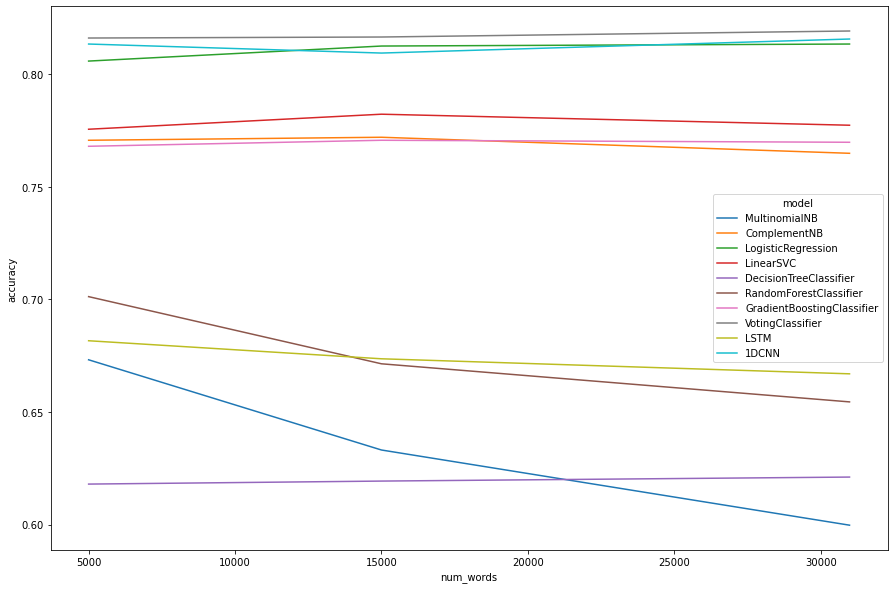

In [31]:
ax = plt.subplots(figsize=(15,10))
ax = sns.lineplot(x='num_words', y='accuracy', hue='model', data=tm.results)

위 결과를 보면 크게 3가지 그룹으로 나누어 볼 수 있다.

1) **VotingClassifier**, 1DCNN, LogisticRegression  
2) LinearSVC, ComplementNB, GradientBoostingClassifier  
3) RandomForestClassifier, LSTM, MultinomialNB, DecisionTreeClassifier  

이 중 세 번째 그룹은 사용하는 단어 수가 많아질수록 성능이 떨어지는 모습을 보인다.  
하지만 성능이 제일 좋은 그룹은 사용하는 단어 수가 많을수록 조금씩 성능이 향상됨을 알 수 있다.

VotingClassifier나 GradientBoostingClassfier의 경우는 포함하는 모델들의 앙상블을 통해 성능향상을 보인 것으로 추측한다.

### 루브릭
---
아래의 기준을 바탕으로 프로젝트를 평가합니다.

|평가문항|상세기준|
|:---|:---|
|1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?|3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.|
|2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?|Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.|
|3. 생성모델의 metric(BLEU 등) 기준 이상 높은 성능이 확인되었는가?|동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.|

### Postscript
---
- 이것저것 실험해보고 싶은 것은 많이 생각나는데 시간이 없어 못 하겠다.
- 이번 프로젝트는 일단 여기까지.

### Reference
---
- [6) 네이버 영화 리뷰 감성 분류하기(Naver Movie Review Sentiment Analysis) - 딥 러닝을 이용한 자연어 처리 입문](https://wikidocs.net/44249)
- [딥러닝하기 7편. LSTM을 이용한 뉴스 분류하기 : 네이버 블로그](https://m.blog.naver.com/PostView.nhn?blogId=htk1019&logNo=221255254613&proxyReferer=https:%2F%2Fwww.google.com%2F)
- [3) 로이터 뉴스 분류하기(Reuters News Classification) - 딥 러닝을 이용한 자연어 처리 입문](https://wikidocs.net/22933)
- [3) 1D CNN으로 IMDB 리뷰 분류하기 - 딥 러닝을 이용한 자연어 처리 입문](https://wikidocs.net/80783)